In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=79171aec91c09e58ed3ee887c918dbfe4f0f761c5ff336d7315706aff6e74a42
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


* https://www.kaggle.com/abhishek/accelerator-power-hour-pytorch-tpu
* https://www.kaggle.com/kevin9000/melanoma-beginner-cnn-using-pytorch
* https://www.kaggle.com/abhishek/melanoma-detection-with-pytorch?scriptVersionId=35193166
* https://www.kaggle.com/nvnvashisth/pytorch-efficientnet-b0-gpu
* https://www.kaggle.com/shebinscaria/siim-isic-efficientnet-starter-code
* https://www.youtube.com/watch?v=QxJgKPdEBV4
* https://www.youtube.com/watch?v=WaCFd-vL4HA
* https://towardsdatascience.com/cuda-error-device-side-assert-triggered-c6ae1c8fa4c3

In [2]:
!pip install wtfml==0.0.2

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image

from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import efficientnet_pytorch

import albumentations as A

from wtfml.utils import EarlyStopping
from wtfml.engine import Engine
from wtfml.data_loaders.image import ClassificationLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from wtfml.classification import ClassificationDataLoader

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Exploring Dataset

In [4]:
train_dir = '../input/siic-isic-224x224-images/train'
test_dir = '../input/siic-isic-224x224-images/test'

In [5]:
t = os.listdir(train_dir)

t1 = os.listdir(test_dir)
print(len(t),len(t1),len(t)+len(t1))

33126 10982 44108


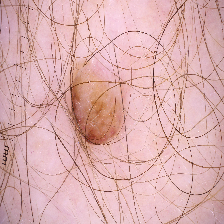

In [6]:
imgpath = '../input/siic-isic-224x224-images/test/ISIC_0052060.png'
img = Image.open(imgpath)
img

In [7]:
img2np = np.array(img)
img2np.shape

(224, 224, 3)

In [8]:
ten = torch.from_numpy(img2np)
ten.shape

torch.Size([224, 224, 3])

## Create folds in dataset

In [9]:
input_path = '../input/siim-isic-melanoma-classification/train.csv'
df = pd.read_csv(input_path)
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [10]:
df['kfold'] = -1
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,kfold
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,-1
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,-1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,-1
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,-1
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,-1


In [11]:
df.sample(frac = 1).head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,kfold
18463,ISIC_5613297,IP_1310148,male,75.0,torso,nevus,benign,0,-1
8753,ISIC_2727309,IP_0019713,male,30.0,lower extremity,nevus,benign,0,-1
22411,ISIC_6790442,IP_1517386,male,40.0,torso,unknown,benign,0,-1
18104,ISIC_5517712,IP_2426108,female,50.0,torso,unknown,benign,0,-1
4699,ISIC_1509056,IP_3860796,female,55.0,lower extremity,nevus,benign,0,-1


In [12]:
df = df.sample(frac = 1).reset_index(drop = True) #shuffling the data, and reset index
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,kfold
0,ISIC_4181565,IP_3278850,male,60.0,lower extremity,unknown,benign,0,-1
1,ISIC_1924663,IP_2041319,female,60.0,torso,unknown,benign,0,-1
2,ISIC_8504517,IP_5229014,male,55.0,torso,unknown,benign,0,-1
3,ISIC_3342276,IP_4314793,female,20.0,palms/soles,unknown,benign,0,-1
4,ISIC_5723389,IP_8385941,female,50.0,torso,unknown,benign,0,-1


In [13]:
y = df.target.values
len(y)

33126

Stratified K-Fold

In [14]:
kf = model_selection.StratifiedKFold(n_splits=5)
for fold_,(train_idx, test_idx) in enumerate(kf.split(X=df,y=y)):
    df.loc[test_idx,'kfold'] = fold_
df.to_csv('./train_folds.csv')

In [15]:
ddf = pd.read_csv('./train_folds.csv')
ddf

,Unnamed: 0,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,kfold
0,0,ISIC_4181565,IP_3278850,male,60.0,lower extremity,unknown,benign,0,0
1,1,ISIC_1924663,IP_2041319,female,60.0,torso,unknown,benign,0,0
2,2,ISIC_8504517,IP_5229014,male,55.0,torso,unknown,benign,0,0
3,3,ISIC_3342276,IP_4314793,female,20.0,palms/soles,unknown,benign,0,0
4,4,ISIC_5723389,IP_8385941,female,50.0,torso,unknown,benign,0,0
...,...,...,...,...,...,...,...,...,...,...
33121,33121,ISIC_8468778,IP_3690477,male,60.0,head/neck,unknown,benign,0,4
33122,33122,ISIC_0892980,IP_0687884,male,65.0,torso,unknown,benign,0,4
33123,33123,ISIC_7083105,IP_0175414,male,60.0,torso,unknown,benign,0,4
33124,33124,ISIC_6023504,IP_7940004,female,75.0,lower extremity,unknown,benign,0,4


## Custom Dataset

In [16]:
# fold is an integer for k-fold.val kfold is fold rest training
def train(fold):
    training_data_path = train_dir
    df = pd.read_csv('./train_folds.csv')
    device = "cuda"
    epochs = 50
    train_bs = 32
    valid_bs = 16
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    # Normalize the images
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    

## Model Transfer Learning

In [17]:
# fold is an integer ie if fold == that no then val else train
def train(fold):
    training_data_path = "../input/siic-isic-224x224-images/train/"
    df = pd.read_csv("/kaggle/working/train_folds.csv")
    device = "cuda"
    epochs = 50
    train_bs = 32
    valid_bs = 16

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    

In [18]:
# IMP for Stratified K-Folds
fold = 0

In [19]:
training_data_path = "../input/siic-isic-224x224-images/train/"
df = pd.read_csv("/kaggle/working/train_folds.csv")

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
    
df_train = df[df.kfold != fold].reset_index(drop=True)
df_valid = df[df.kfold == fold].reset_index(drop=True)

In [20]:
# df_train.image_name.values.tolist()
device = "cuda"
epochs = 50
train_bs = 32
valid_bs = 16

In [21]:
#Train
training_data_path = "../input/siic-isic-224x224-images/train/"

train_aug = A.Compose(
        [
            A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
            A.Flip(p=0.5)  
        ]          
    )

train_images = df_train.image_name.values.tolist()
train_images = [os.path.join(training_data_path, i + '.png') for i in train_images]
train_targets = df_train.target.values


train_dataset = ClassificationLoader(
    image_paths=train_images,
    targets=train_targets,
    resize=None,
    augmentations=train_aug,
)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_bs, shuffle=True, num_workers=4)

In [22]:
# Valid
valid_images = df_valid.image_name.values.tolist()
valid_images = [os.path.join(training_data_path, i + ".png") for i in valid_images]
valid_targets = df_valid.target.values

valid_aug = A.Compose([
    A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)
])

valid_dataset = ClassificationLoader(
    image_paths=valid_images,
    targets=valid_targets,
    resize=None,
    augmentations=valid_aug,
)

valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4)

## Model Training - Efficient Net

In [23]:
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.base_model = efficientnet_pytorch.EfficientNet.from_pretrained(
            'efficientnet-b4'
        )
        self.base_model._fc = nn.Linear(
            in_features=1792, 
            out_features=1, 
            bias=True
        )
        
    def forward(self, image, targets):
        out = self.base_model(image)
        loss = nn.BCEWithLogitsLoss()(out, targets.view(-1, 1).type_as(out))
        return out, loss

In [24]:
model = EfficientNet()
model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
    

In [25]:
# net = efficientnet_pytorch.EfficientNet.from_pretrained(
#             'efficientnet-b4'
#         )

In [26]:
device

'cuda'

In [27]:
# for param in net.parameters():
#     param.requires_grad = False
    
# _fc = nn.Linear(1792,1)
# net._fc = _fc

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=3,
        threshold=0.001,
        mode="max"
    )

es = EarlyStopping(patience=5, mode="max")

In [31]:
epochs = 50
for epoch in range(epochs):
        train_loss = Engine.train(train_loader, model, optimizer, device=device)
        predictions, valid_loss = Engine.evaluate(
            valid_loader, model, device=device
        )
        predictions = np.vstack((predictions)).ravel()
        auc = metrics.roc_auc_score(valid_targets, predictions)
        print(f"Epoch = {epoch}, AUC = {auc}")
        scheduler.step(auc)

        es(auc, model, model_path=f"model_fold_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break

  0%|          | 0/829 [00:00<?, ?it/s]

Epoch = 0, AUC = 0.8915374241845283
Validation score improved (-inf --> 0.8915374241845283). Saving model!


  0%|          | 0/829 [00:00<?, ?it/s]

Epoch = 1, AUC = 0.8895625123924402
EarlyStopping counter: 1 out of 5


  0%|          | 0/829 [00:00<?, ?it/s]

Epoch = 2, AUC = 0.8744985575527903
EarlyStopping counter: 2 out of 5


  0%|          | 0/829 [00:00<?, ?it/s]

Epoch = 3, AUC = 0.8683335237337388
EarlyStopping counter: 3 out of 5


  0%|          | 0/829 [00:00<?, ?it/s]

Epoch = 4, AUC = 0.8706432776182353
EarlyStopping counter: 4 out of 5


100%|██████████| 415/415 [00:36<00:00, 11.40it/s, loss=0.0867]

Epoch = 5, AUC = 0.8661616460049398
EarlyStopping counter: 5 out of 5
Early stopping


In [32]:
# torch.save
torch.save(model.state_dict(), './modetor.pt')

In [40]:
#Test
def predict(fold):
    print(f"Generating Predictions for saved model, fold = {fold+1}")
    test_data_path = "/kaggle/input/siic-isic-224x224-images/test"
    df_test = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv")
    df_test.loc[:,'target'] = 0
    
    #model_path = "f'/kaggle/working/model_fold{fold}'"
    #model_path = '/kaggle/working/model_fold0_epoch0.bin'
    model_path = './model_fold_0.bin'
    
    device = 'cuda'
    
    test_bs = 16
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    
    test_aug = A.Compose(
        [
            A.Normalize(mean, std, max_pixel_value=255.0, always_apply=True,p=1.0)
        ]
    )
    test_images_list = df_test.image_name.values.tolist()
    test_images = [os.path.join(test_data_path,i + '.png') for i in test_images_list]
    test_targets = df_test.target.values
    
    test_dataset = ClassificationLoader(
        image_paths = test_images,
        targets= test_targets,
        resize = None,
        augmentations = test_aug
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = test_bs,
        shuffle = False,
        num_workers=4
    )
    #Earlier defined class for model
    model = EfficientNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    predictions_op = Engine.predict(
        test_loader,
        model,
        device
    )
    return np.vstack((predictions_op)).ravel()

In [41]:
# prediction
pred = predict(0)

Generating Predictions for saved model, fold = 1
Loaded pretrained weights for efficientnet-b4


100%|██████████| 687/687 [01:02<00:00, 10.93it/s]


In [42]:
predictions = pred
sample = pd.read_csv("../input/siim-isic-melanoma-classification/sample_submission.csv")
sample.loc[:, "target"] = predictions
sample.to_csv("submission.csv", index=False)

In [ ]:
# net.to(device)
# optimizer = optim.Adam(net.parameters(), lr=0.01)
# criterion = nn.BCEWithLogitsLoss()

In [ ]:
# for epoch in range(6): 
#         running_loss = 0.0
#         for i, data in enumerate(train_loader, 0):
#             inputs, labels = data['image'].to(device), data['targets'].to(device)
#             optimizer.zero_grad()
#             outputs = net(inputs)
            
#             labels = labels.unsqueeze(1)
#             labels = labels.float()
            
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             if i % 50 == 49:   
# #                 tb_count += 1
# #                 tb.add_scalar('Running Loss', running_loss/100, tb_count)
#                 print('[%d, %5d] loss: %.5f' %(epoch + 1, i + 1, running_loss / 50))
#                 running_loss = 0.0

#         if epoch % 2 == 1:
#             print('At the end of epoch %d' %(epoch+1))
#             correct = 0
#             total = 0
#             with torch.no_grad():
#                 preds=[]
#                 targets=[]
#                 for data in train_loader:
#                     images, labels = data['image'].to(device), data['targets'].to(device)
#                     outputs = net(images)
                    
#                     labels = labels.unsqueeze(1)
#                     labels = labels.float()
                    
#                     _, predicted = torch.max(outputs.data, 1)
#                     preds += list(predicted.cpu().detach().numpy().squeeze())
#                     targets += list(labels.cpu().detach().numpy().squeeze())
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#     #             tb.add_scalar('Train Accuracy', 100 * correct / total, epoch+1)
#             print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
# #             print('Training Confusion Matrix:')
# #             print(confusion_matrix(targets, preds))

#             with torch.no_grad():
#                 for data in valid_loader:
#                     images, labels = data['image'].to(device), data['targets'].to(device)
#                     outputs = net(images)
#                     _, predicted = torch.max(outputs.data, 1)
#                     preds += list(predicted.cpu().detach().numpy().squeeze())
#                     targets += list(labels.cpu().detach().numpy().squeeze())
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()
#     #             tb.add_scalar('Test Accuracy', 100 * correct / total, epoch+1)
#             print('Accuracy of the network on the validation images: %d %%' % (100 * correct / total))
# #             print('Validation Confusion Matrix:')
# #             print(confusion_matrix(targets, preds))

# #     tb.close()
# print('Finished Training')